In [1]:
import json
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt

from localconfig import LocalConfig

import re

In [2]:
import os
import json
import pandas as pd
from configparser import ConfigParser

def load_experiment_data(base_dir):
    results = []
    settings_list = []
    
    # Walk through the base directory
    for root, dirs, files in os.walk(base_dir):
        if 'machine0' in dirs:  # Check if we're at the experiment level
            experiment_dir = os.path.join(root, 'machine0')
            json_files = [f for f in os.listdir(experiment_dir) if f.endswith('.json')]
            ini_files = [f for f in os.listdir(experiment_dir) if f.endswith('.ini')]
            
            # Extract timestamp from folder name
            # Assumes the last part after the last underscore is the timestamp
            timestamp = root.split('_')[-1]  
            
            # Load JSON results for each node
            experiment_results = {'timestamp': timestamp}
            for json_file in json_files:
                with open(os.path.join(experiment_dir, json_file), 'r') as f:
                    data = json.load(f)
                    node_id = json_file.split('_')[0]  # Assumes filename format '0_results.json'
                    experiment_results[node_id] = data
            
            results.append(experiment_results)
            
            # Load INI configuration file
            if ini_files:
                config = ConfigParser()
                config.read(os.path.join(experiment_dir, ini_files[0]))
                config_dict = {f"{section}_{key}": value for section in config.sections() for key, value in config.items(section)}
                config_dict['timestamp'] = timestamp
                settings_list.append(config_dict)
    
    # Create DataFrame for settings
    df_settings = pd.DataFrame(settings_list)
    
    # Optional: Convert results into a DataFrame for analysis
    df_results = pd.json_normalize(results)

    df_long = df_results.melt(id_vars=['timestamp'], var_name='node_metric_iter', value_name='value')

    df_long[['node', 'metric', 'iteration']] = df_long['node_metric_iter'].str.split('.', expand=True)

    
    return df_results, df_settings, df_long

In [3]:
def calculate_average_loss_mia_update(df):
    average_loss_updates = []
    
    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        loss_updates = []
        
        # Iterate over each node in the row
        for node in row.index:
            if node.startswith('timestamp'):
                continue
            if 'loss_mia_update' in node:
                print(node)
                # Collect all loss_mia_update values for this experiment
                updates = pd.Series(row[node]).astype(float)
                loss_updates.append(updates)
        
        if loss_updates:
            # Concatenate all Series into a DataFrame and calculate the mean across rows (nodes)
            loss_updates_df = pd.concat(loss_updates, axis=1)
            mean_loss_updates = loss_updates_df.mean(axis=1)
            mean_loss_updates.name = row['timestamp']
            average_loss_updates.append(mean_loss_updates)
    
    # Combine all experiment averages into a single DataFrame
    average_loss_df = pd.concat(average_loss_updates, axis=1)
    return average_loss_df

In [4]:
def plot_metric(df_long, metric_name):
    df_loss_mia_update = df_long[df_long['metric'] == metric_name]

    df_loss_mia_update['iteration'] = df_loss_mia_update['iteration'].astype(int)

    # Group by timestamp and iteration, then calculate the average
    # stats_result = df_loss_mia_update.groupby(['timestamp', 'iteration']).agg({'value': 'mean'}).reset_index()
    stats_result = df_loss_mia_update.groupby(['timestamp', 'iteration'])['value'].agg(['mean', 'std']).reset_index()

    fig, ax = plt.subplots(figsize=(10, 6))

    # for label, grp in stats_result.groupby('timestamp'):
    #     ax.plot(grp['iteration'], grp['value'], label=label)

    for label, grp in stats_result.groupby('timestamp'):
        ax.errorbar(grp['iteration'], grp['mean'], yerr=grp['std'], label=label, fmt='-o', capsize=5)  # fmt specifies the line style

    ax.set_xlabel('Iteration')
    ax.set_ylabel(metric_name)
    ax.set_title(metric_name+' by Iteration for Each Experiment')
    ax.legend(title='Timestamp', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()

In [5]:
def plot_cdf(df_long, metric_name):

    # Assuming df_long is already available and contains 'timestamp', 'metric', 'iteration', 'value'
    # Example DataFrame preparation steps are assumed to be completed.

    # Filter the DataFrame to include only the 'loss_mia_update' metric
    loss_data = df_long[df_long['metric'] == metric_name]

    # Initialize a plot
    fig, ax = plt.subplots()
    ax.set_title('Cumulative Distribution Function of '+metric_name)
    ax.set_xlabel(metric_name)
    ax.set_ylabel('CDF')

    #add a line at 0.5 and 0.9
    ax.axhline(y=0.5, color='k', linestyle='solid')
    ax.axhline(y=0.9, color='k', linestyle='solid')

    # Calculate and plot the CDF for each experiment
    for label, grp in loss_data.groupby('timestamp'):
        values = grp['value'].to_numpy()
        values_sorted = np.sort(values)
        cdf = np.arange(1, len(values_sorted) + 1) / len(values_sorted)
        ax.plot(values_sorted, cdf, label=label, marker='.', linestyle='none')

    ax.legend(title='Timestamp', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()

In [6]:
def plot_cdf_zoom(df_long, metric_name):
    # Filter the DataFrame to include only the specified metric
    loss_data = df_long[df_long['metric'] == metric_name]

    # Initialize the main plot
    fig, ax = plt.subplots()
    ax.set_title('Cumulative Distribution Function of ' + metric_name)
    ax.set_xlabel(metric_name)
    ax.set_ylabel('CDF')

    # Add lines at specific CDF levels for reference
    ax.axhline(y=0.5, color='k', linestyle='solid')
    ax.axhline(y=0.9, color='k', linestyle='solid')

    # Calculate and plot the CDF for each experiment
    for label, grp in loss_data.groupby('timestamp'):
        values = grp['value'].to_numpy()
        values_sorted = np.sort(values)
        cdf = np.arange(1, len(values_sorted) + 1) / len(values_sorted)
        ax.plot(values_sorted, cdf, label=label, marker='.', linestyle='none')

    ax.legend(title='Timestamp', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)

    # Creating an inset axis for zoomed-in view
    axins = ax.inset_axes([0.5, 0.5, 0.47, 0.47])  # [x, y, width, height] in figure coordinates
    for label, grp in loss_data.groupby('timestamp'):
        values = grp['value'].to_numpy()
        values_sorted = np.sort(values)
        cdf = np.arange(1, len(values_sorted) + 1) / len(values_sorted)
        axins.plot(values_sorted, cdf, marker='.', linestyle='none')

    # Set x and y limits for the zoomed area, e.g., the bottom left part of the CDF plot
    x1, x2, y1, y2 = values_sorted[0], values_sorted[int(len(values_sorted)*0.07)], 0, 0.1
    axins.set_xlim(x1-0.001, x2)
    axins.set_ylim(y1, y2)
    axins.grid(True)

    # Connect the inset and the main plot with lines
    ax.indicate_inset_zoom(axins, edgecolor="black")

    plt.show()

In [7]:
def plot_average_mia_per_node(data, experiment_timestamp):
    columns_of_interest = [col for col in data.columns if 'loss_mia_update' in col]
    node_data = data[columns_of_interest]

    # Extract node number and restructure DataFrame
    # Assuming the format is 'node.metric.iteration'
    split_columns = node_data.columns.str.split('.', expand=True)
    node_data.columns = pd.MultiIndex.from_arrays(split_columns.values.T, names=['node', 'metric', 'iteration'])

    # Calculate the mean across all iterations for each node
    average_loss = node_data.mean(axis=1, level='node')

    # Convert to a suitable format for plotting
    average_loss = average_loss.mean(axis=0)  # Get mean across all timestamps if necessary
    average_loss = average_loss.droplevel('metric')  # Drop the metric level if all are the same

    # Plot
    average_loss.plot(kind='bar')
    plt.title('Average Loss MIA Update per Node')
    plt.xlabel('Node')
    plt.ylabel('Average Loss')
    plt.xticks(rotation=0)  # Keep node labels horizontal
    plt.show()

In [39]:
def plot_aggr_metric_cdf(df, metric, agg_func='max'):
    df = df[df['metric'] == metric]

    if agg_func == 'min':
        # Group by node and timestamp and find the minimum 'value'
        values = df.groupby(['node', 'timestamp'])['value'].min().reset_index()
    else:
        # Group by node and timestamp and find the maximum 'value'
        values = df.groupby(['node', 'timestamp'])['value'].max().reset_index()

    # Get unique timestamps for coloring
    timestamps = values['timestamp'].unique()
    colors = plt.cm.viridis(np.linspace(0, 1, len(timestamps)))  # Using a colormap for distinct colors

    plt.figure(figsize=(10, 6))

    for idx, timestamp in enumerate(timestamps):
        # Filter values by timestamp
        subset = values[values['timestamp'] == timestamp]
        
        # Sort values and calculate CDF
        sorted_vals = np.sort(subset['value'])
        cdf = np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)
        
        # Plot
        plt.step(sorted_vals, cdf, where='post', label=f'Timestamp {timestamp}')

    plt.title('CDF of Maximum Values for Each Node by Timestamp')
    plt.xlabel('Max Value')
    plt.ylabel('CDF')
    plt.legend()
    plt.grid(True)
    plt.show()

In [26]:
def plot_box_metric(df,metric):
    df = df[df['metric'] == metric]

    fig, ax = plt.subplots(figsize=(10, 6))

    ax = df.boxplot(column='value', by='timestamp', ax=ax)

    plt.title('')
    plt.suptitle('')

    ax.set_title('Boxplot of '+metric)
    ax.set_xlabel('Timestamp')
    ax.set_ylabel(metric)

    plt.show()

/tmp/ipykernel_828117/3057522950.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss_mia_update['iteration'] = df_loss_mia_update['iteration'].astype(int)


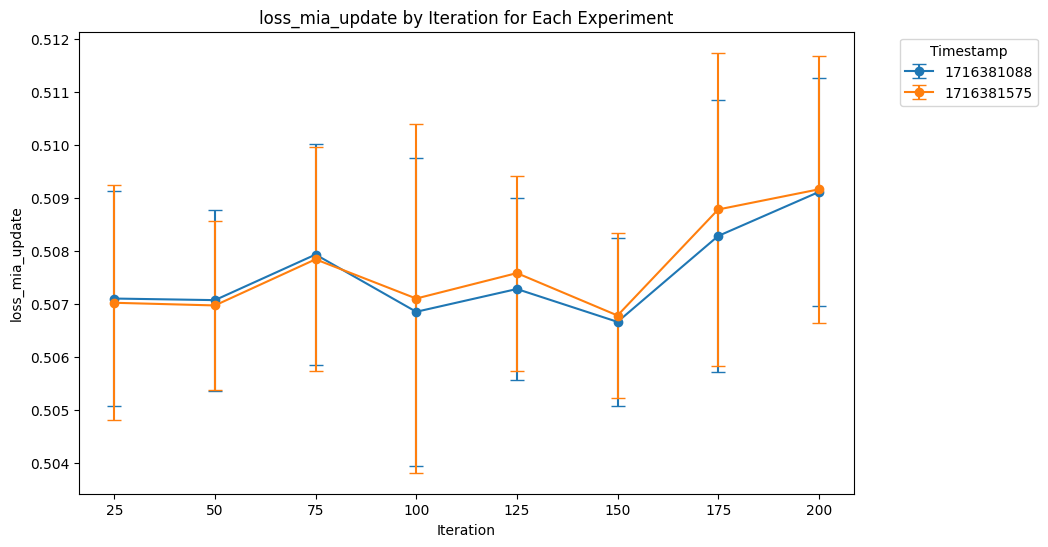

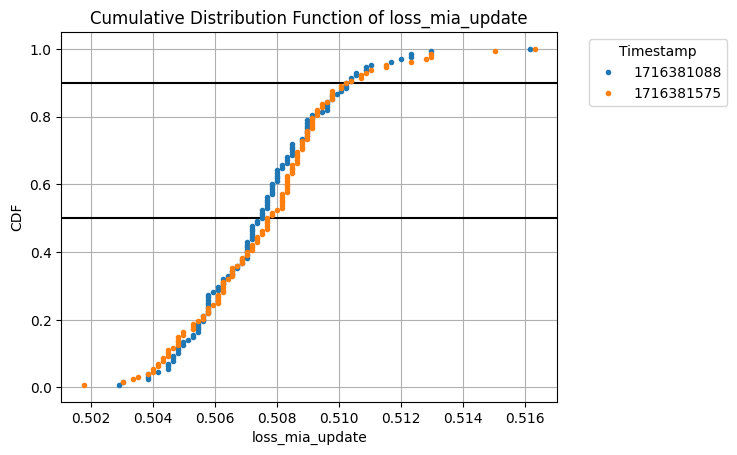

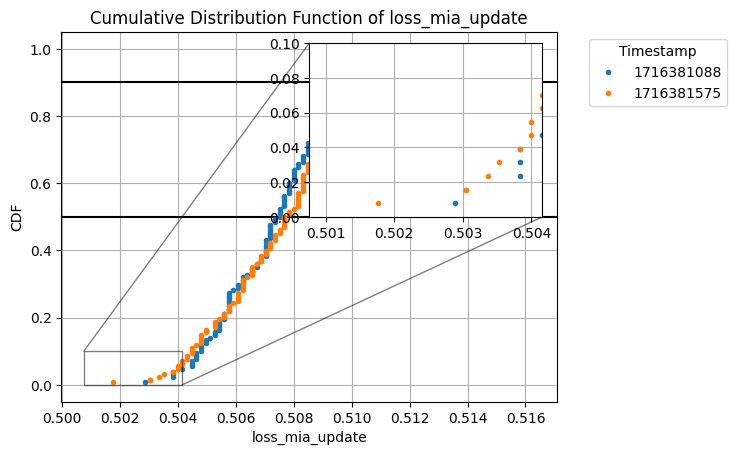

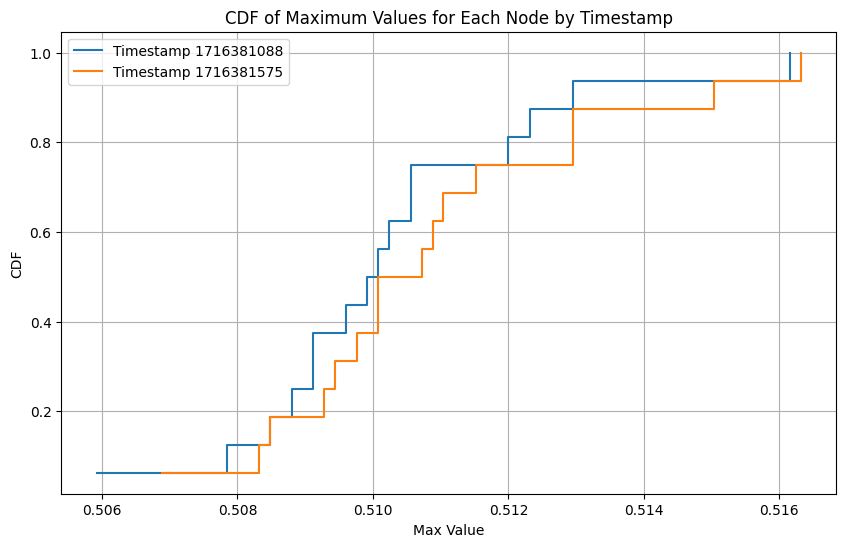

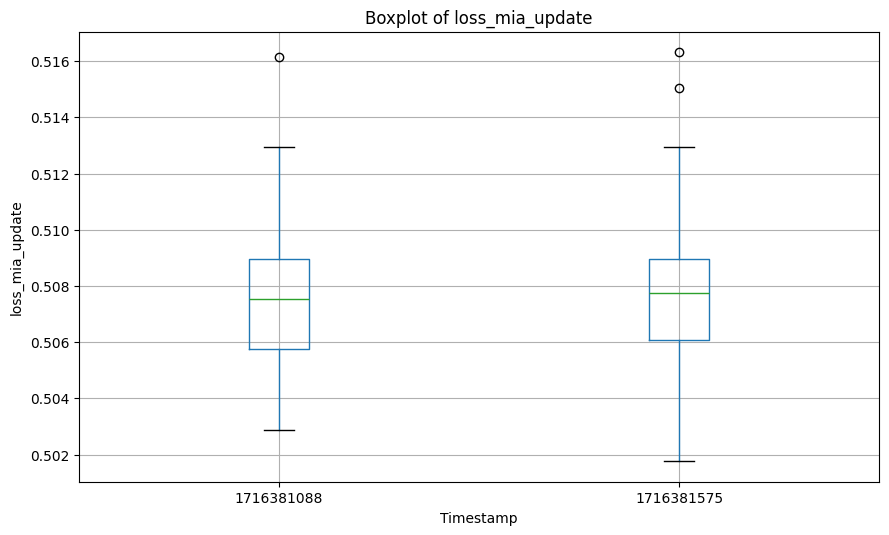

In [40]:
# Specify the base directory containing all experiment folders
base_directory = '/home/andrealagrotteria/decentralizepy/eval/data/echo-16'
experiment_results_df, experiment_settings_df, df_long = load_experiment_data(base_directory)
plot_metric(df_long, 'loss_mia_update')
plot_cdf(df_long, 'loss_mia_update')
plot_cdf_zoom(df_long, 'loss_mia_update')
plot_aggr_metric_cdf(df_long, 'loss_mia_update')
plot_box_metric(df_long, 'loss_mia_update')

/tmp/ipykernel_828117/3057522950.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss_mia_update['iteration'] = df_loss_mia_update['iteration'].astype(int)


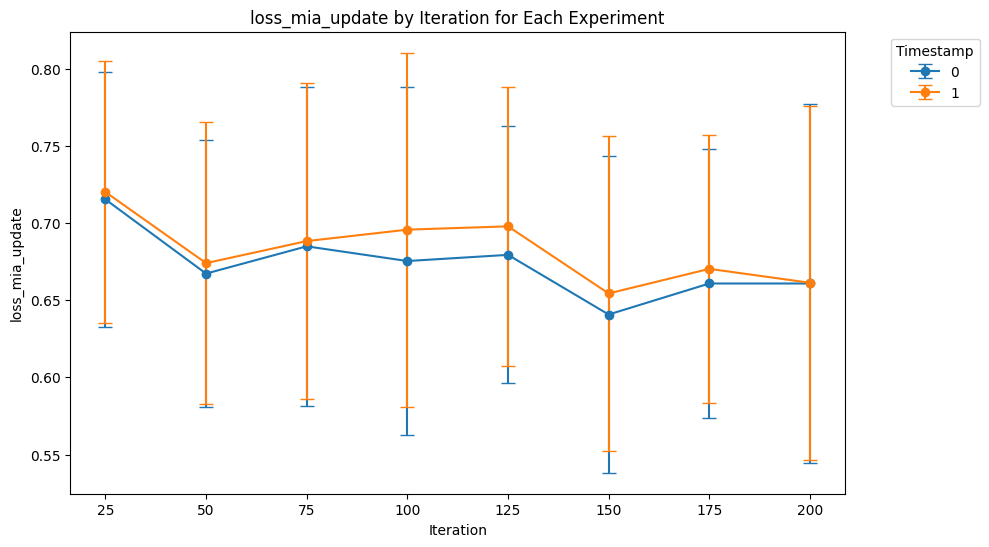

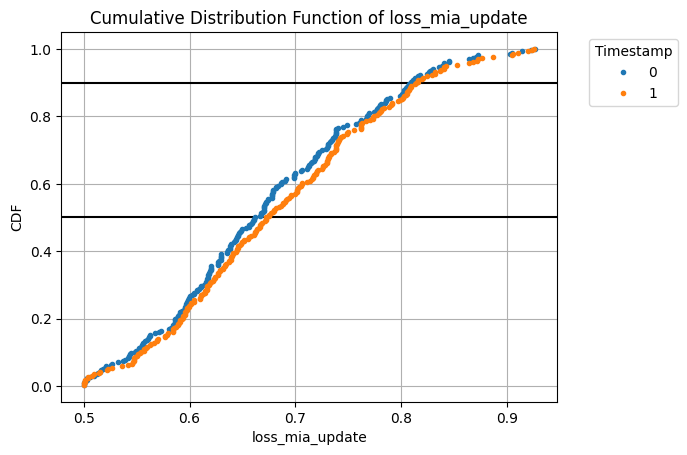

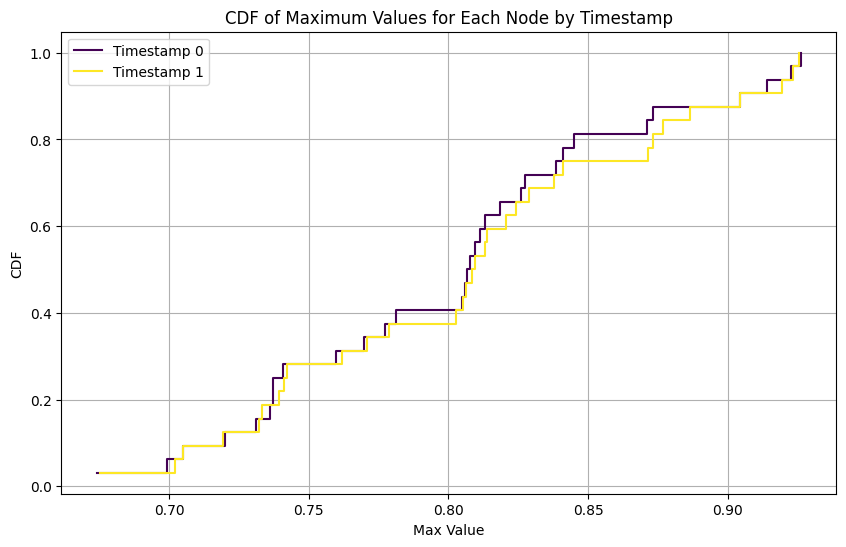

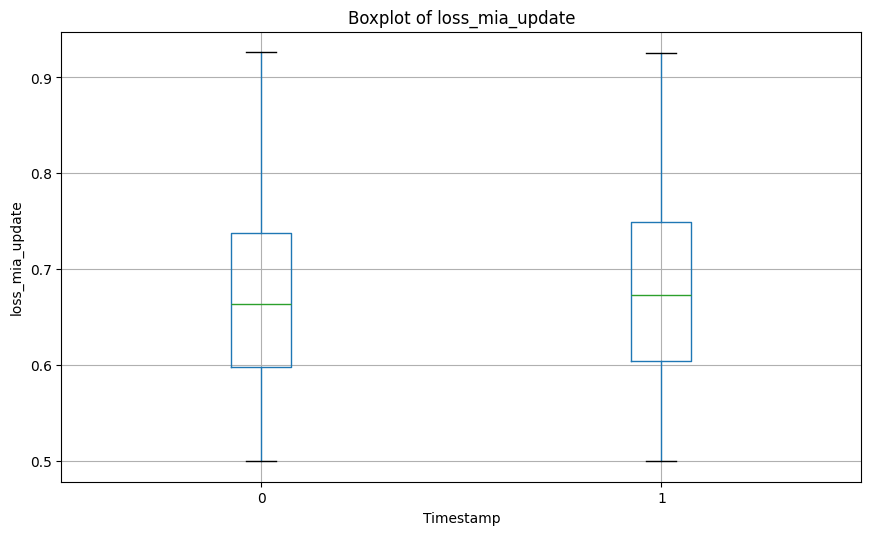

In [32]:
# Specify the base directory containing all experiment folders
base_directory = '/home/andrealagrotteria/decentralizepy/eval/data/echo-32-d4'
experiment_results_df, experiment_settings_df, df_long = load_experiment_data(base_directory)
plot_metric(df_long, 'loss_mia_update')
plot_cdf(df_long, 'loss_mia_update')
plot_aggr_metric_cdf(df_long, 'loss_mia_update')
plot_box_metric(df_long, 'loss_mia_update')

/tmp/ipykernel_828117/3057522950.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss_mia_update['iteration'] = df_loss_mia_update['iteration'].astype(int)


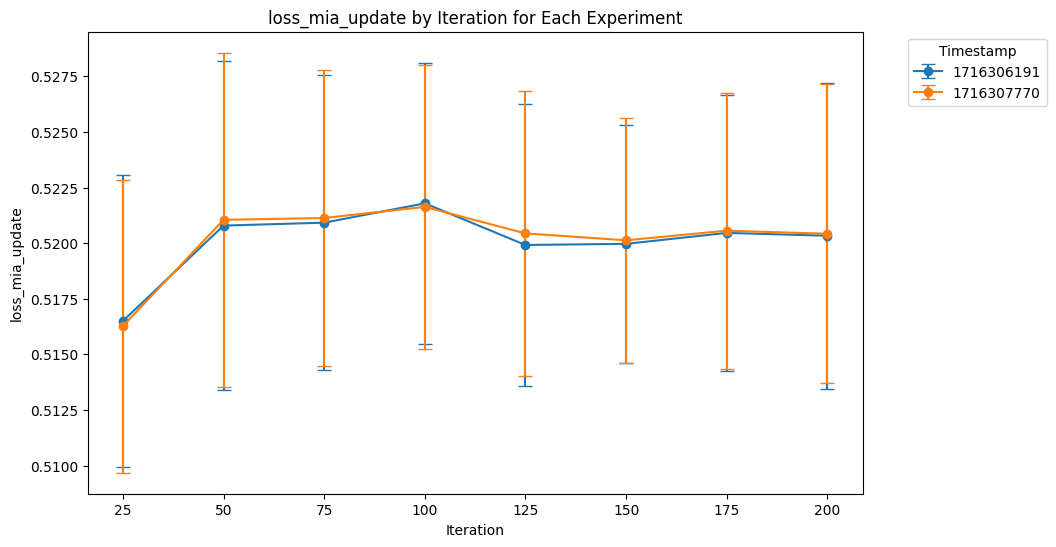

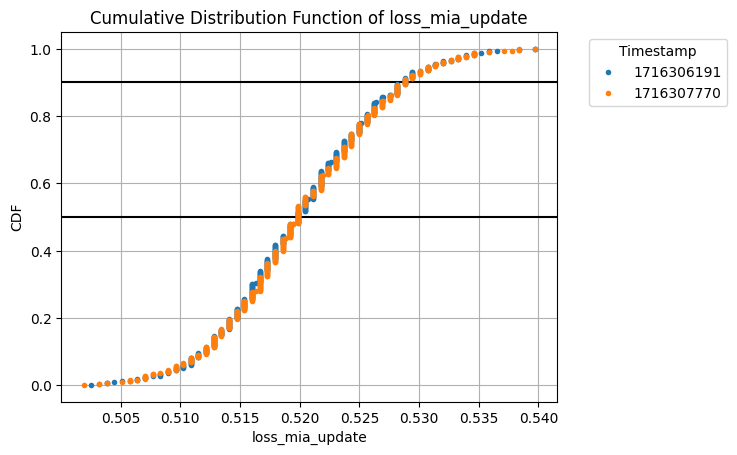

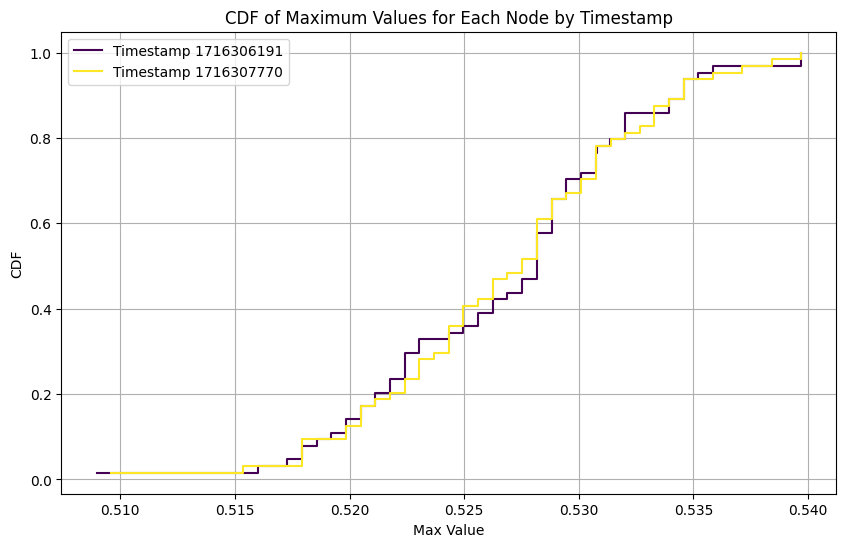

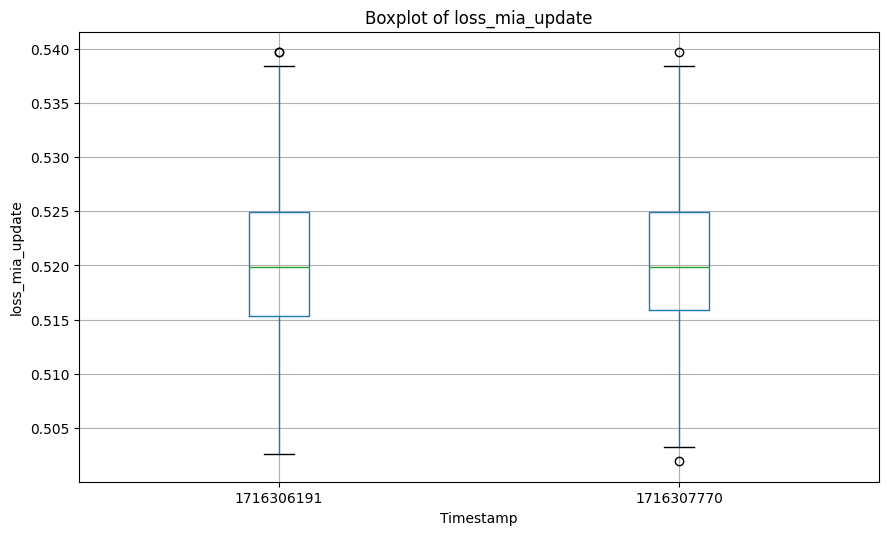

In [34]:
# Specify the base directory containing all experiment folders
base_directory = '/home/andrealagrotteria/decentralizepy/eval/data/echo-64'
experiment_results_df, experiment_settings_df, df_long = load_experiment_data(base_directory)
plot_metric(df_long, 'loss_mia_update')
plot_cdf(df_long, 'loss_mia_update')
plot_aggr_metric_cdf(df_long, 'loss_mia_update')
plot_box_metric(df_long, 'loss_mia_update')

/tmp/ipykernel_828117/3057522950.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss_mia_update['iteration'] = df_loss_mia_update['iteration'].astype(int)


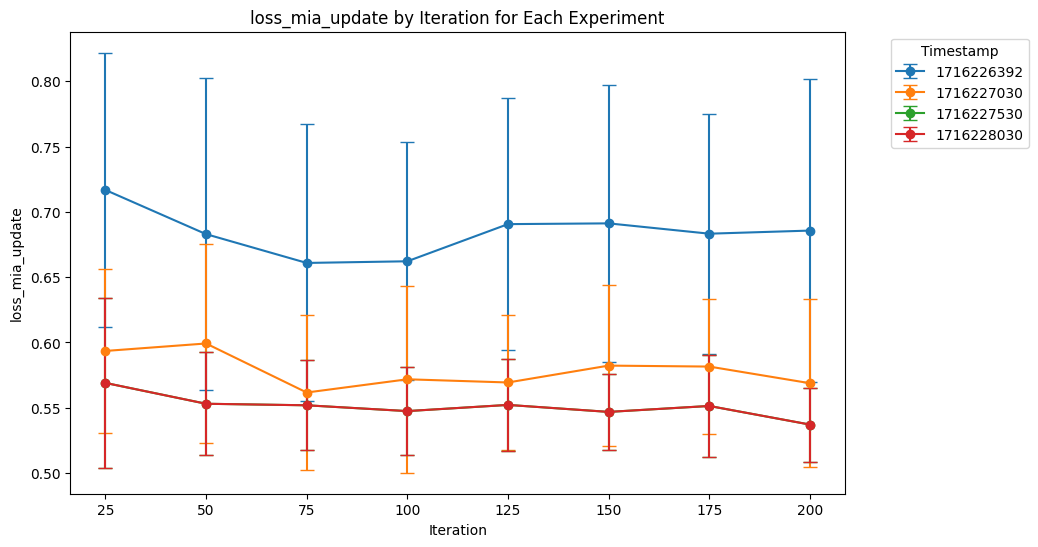

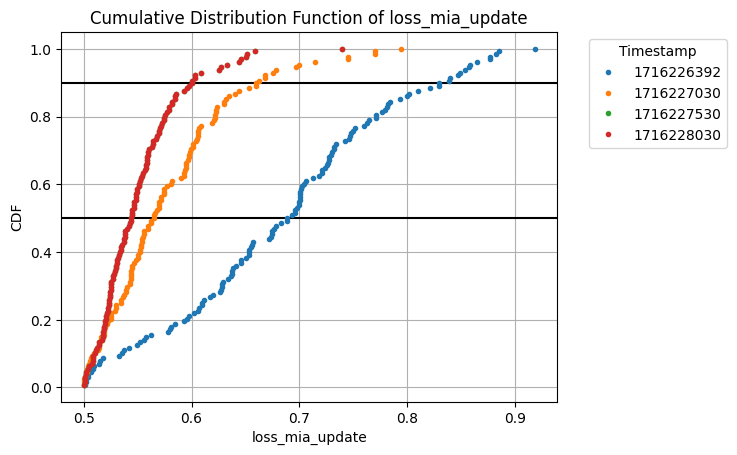

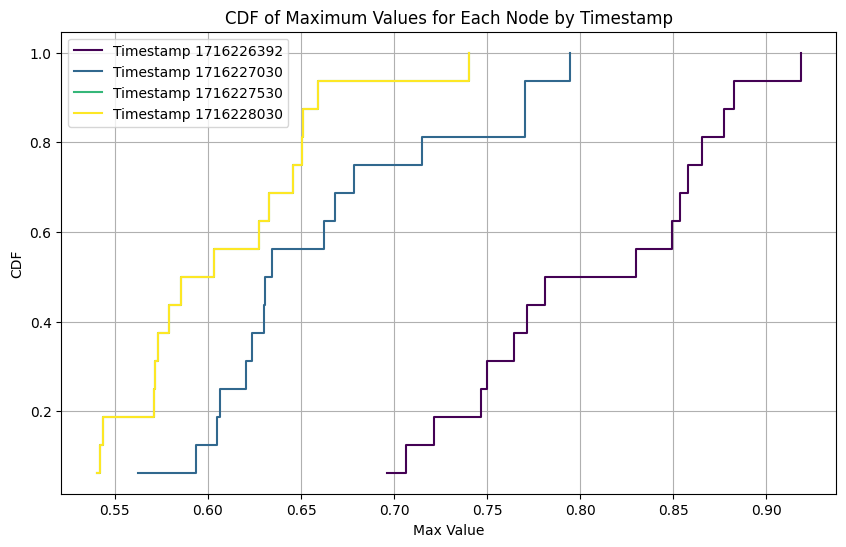

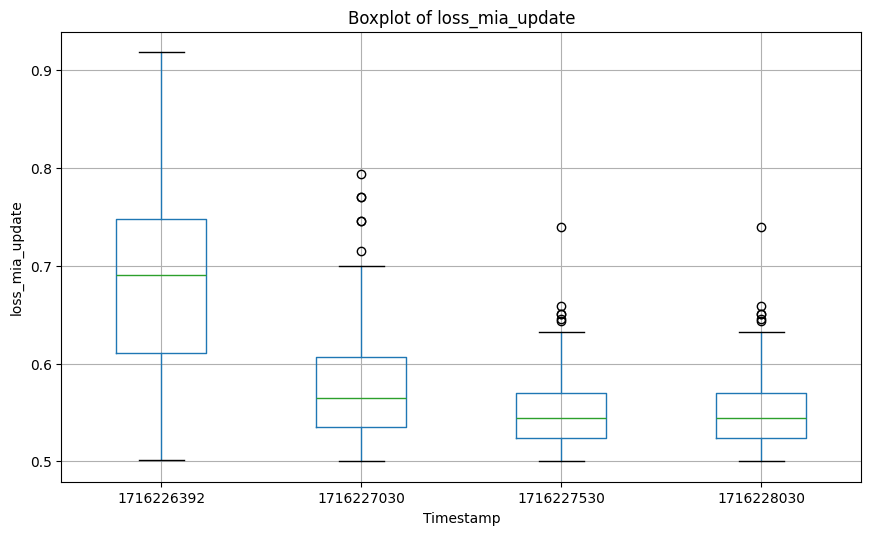

In [36]:
# Specify the base directory containing all experiment folders
base_directory = '/home/andrealagrotteria/decentralizepy/eval/data/echo-16-partition'
experiment_results_df, experiment_settings_df, df_long = load_experiment_data(base_directory)
plot_metric(df_long, 'loss_mia_update')
plot_cdf(df_long, 'loss_mia_update')
plot_aggr_metric_cdf(df_long, 'loss_mia_update')
plot_box_metric(df_long, 'loss_mia_update')

/tmp/ipykernel_828117/3057522950.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss_mia_update['iteration'] = df_loss_mia_update['iteration'].astype(int)


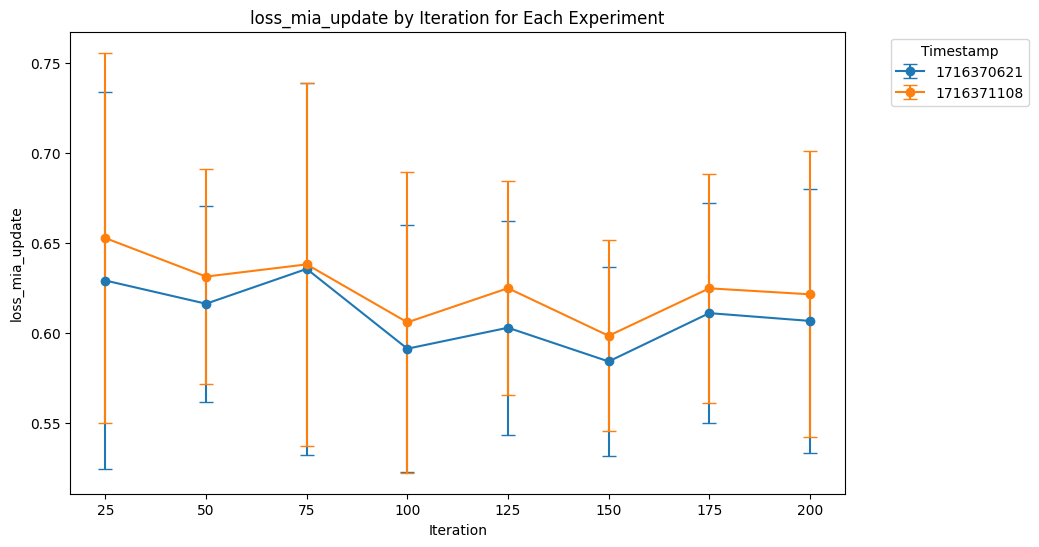

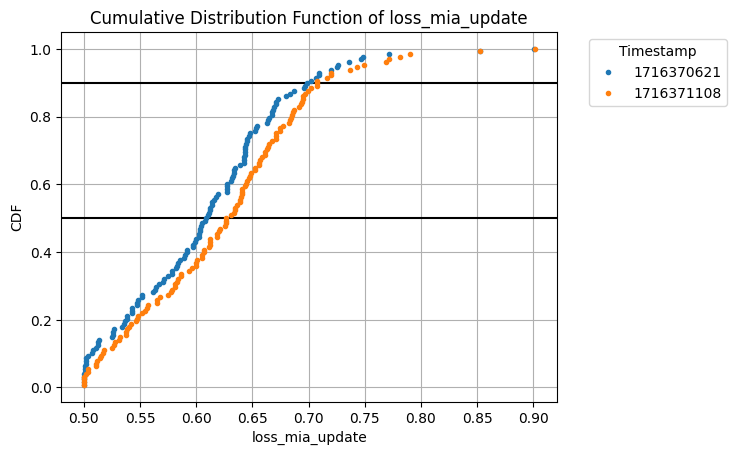

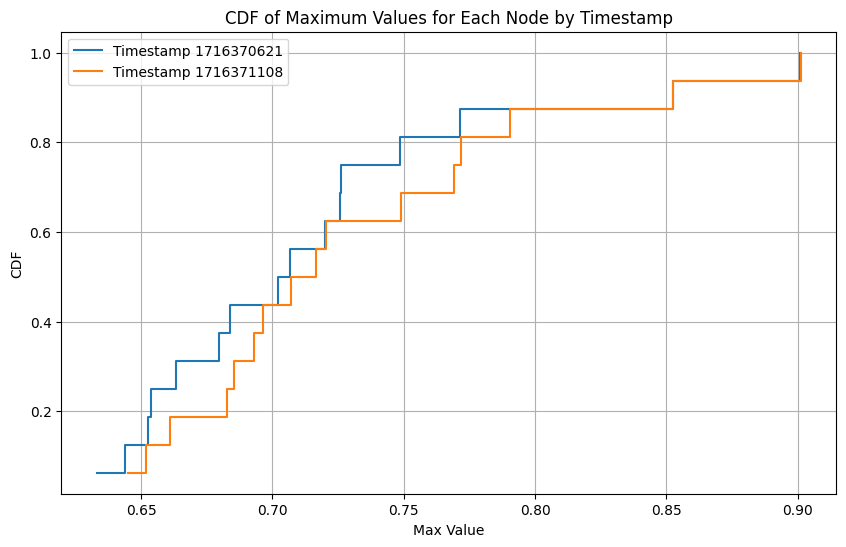

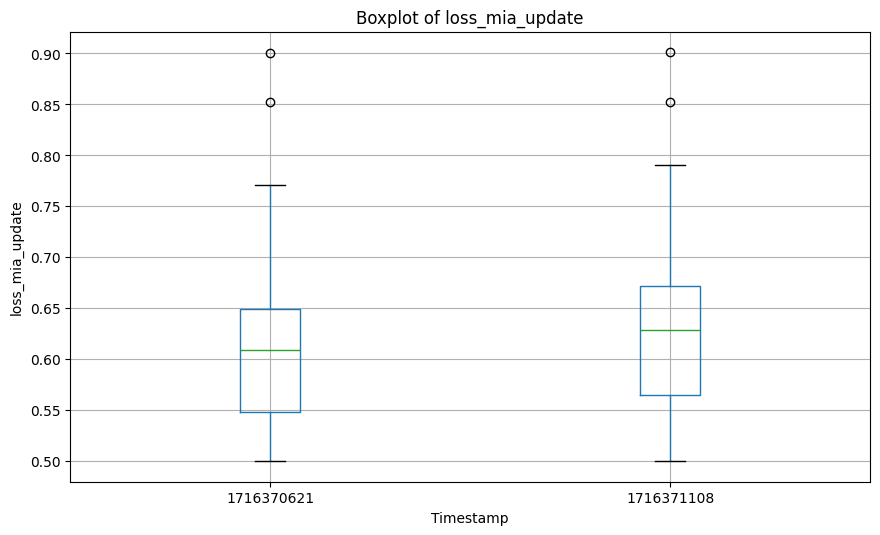

In [41]:
# Specify the base directory containing all experiment folders
base_directory = '/home/andrealagrotteria/decentralizepy/eval/data/echo-16-2shard'
experiment_results_df, experiment_settings_df, df_long = load_experiment_data(base_directory)
plot_metric(df_long, 'loss_mia_update')
plot_cdf(df_long, 'loss_mia_update')
plot_aggr_metric_cdf(df_long, 'loss_mia_update')
plot_box_metric(df_long, 'loss_mia_update')

/tmp/ipykernel_828117/3057522950.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss_mia_update['iteration'] = df_loss_mia_update['iteration'].astype(int)


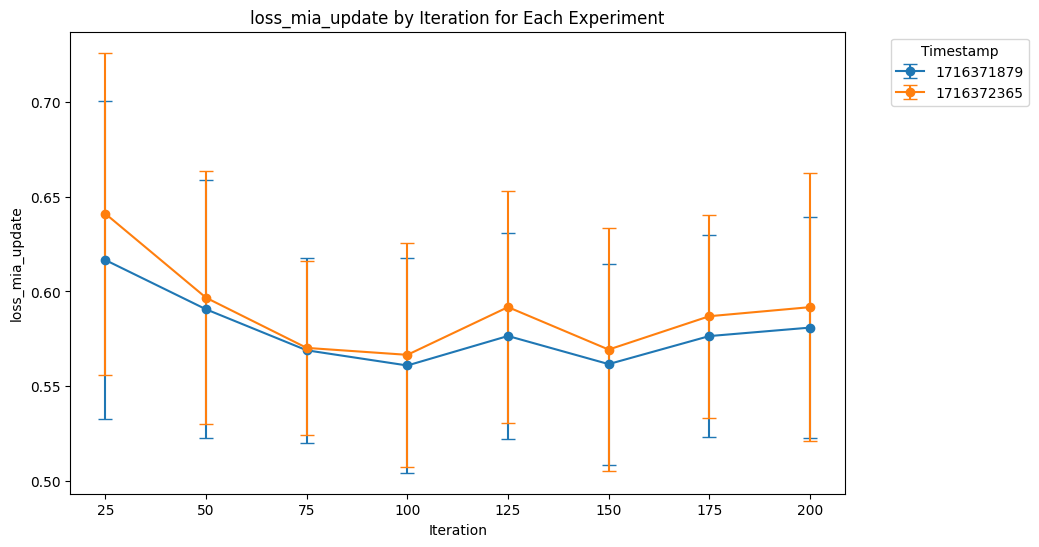

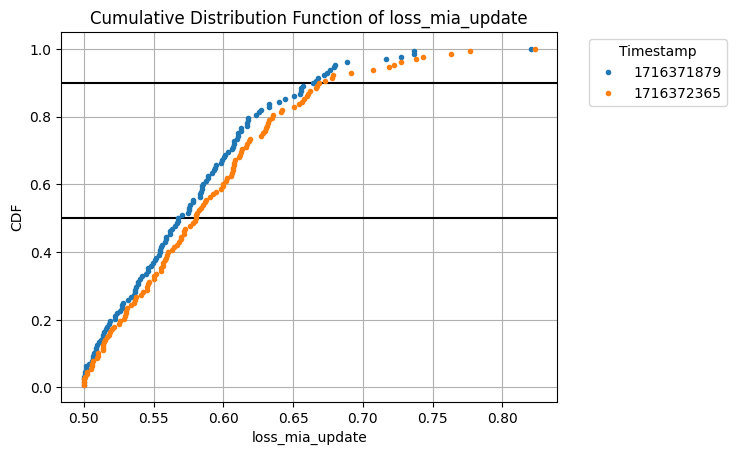

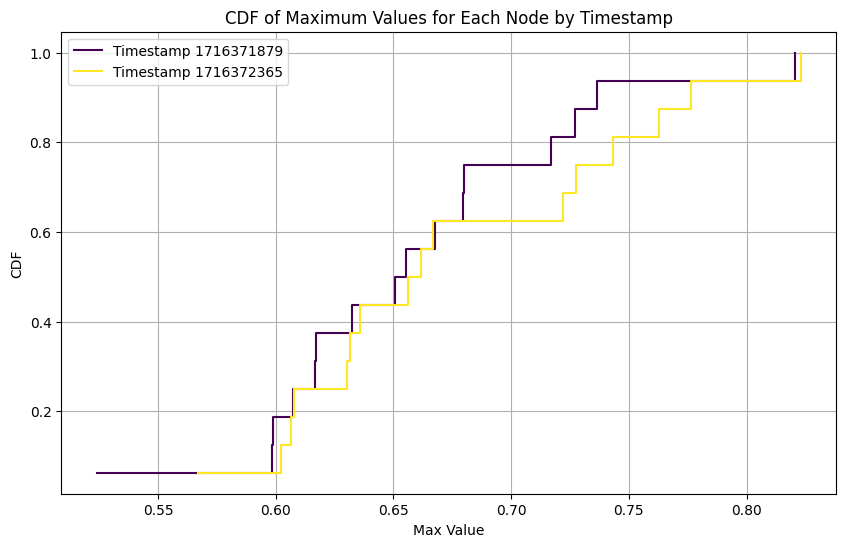

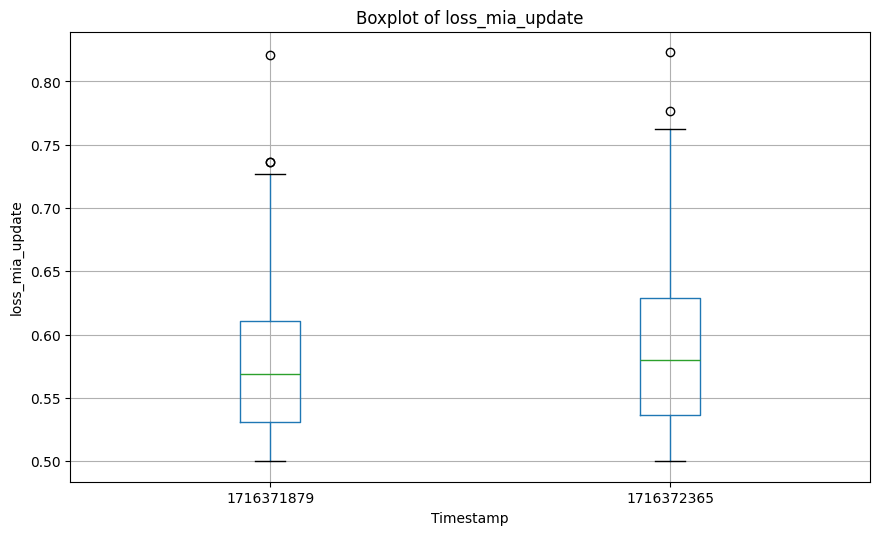

In [38]:
# Specify the base directory containing all experiment folders
base_directory = '/home/andrealagrotteria/decentralizepy/eval/data/echo-16-4shard'
experiment_results_df, experiment_settings_df, df_long = load_experiment_data(base_directory)
plot_metric(df_long, 'loss_mia_update')
plot_cdf(df_long, 'loss_mia_update')
plot_aggr_metric_cdf(df_long, 'loss_mia_update')
plot_box_metric(df_long, 'loss_mia_update')